# Clustering: k-means and GMM

In [1]:
from scipy.stats import multivariate_normal
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
mv_path = "./Assignment 8 datasets/mv.csv"
unif_path = "./Assignment 8 datasets/unif.csv"
mv2_path = "./Assignment 8 datasets/mv2.csv"
mv3_path = "./Assignment 8 datasets/mv3.csv"

# Read in Data
mv_df = pd.read_csv(mv_path, index_col = 0)
unif_df = pd.read_csv(unif_path, index_col = 0)
mv2_df = pd.read_csv(mv2_path, index_col = 0)
mv3_df = pd.read_csv(mv3_path, index_col = 0)

In [3]:
mv_df.head()

,x,y,cat
0,-1.447457,0.912278,0
1,-1.103909,-0.638752,0
2,-0.649668,0.954469,0
3,-1.498370,-0.160686,0
4,-0.951470,-0.369971,0


Cluster Assignments

$$c_i =\text{argmin}_k\ ||x_i - \mu_k||^2.$$

In [4]:
def assign_clusters_k_means(points, clusters): # decides which cluster point is closest to and returns that information
    dist_to_clust=[]
    for c in clusters:
        dists=np.apply_along_axis(np.linalg.norm,1,points-c).reshape(-1,1)
        dist_to_clust.append(dists)    
    dist_to_clust=np.concatenate(dist_to_clust,axis=1)
    def find_min(x):
        m=np.min(x)
        return [1 if n==m else 0 for n in x]
    cluster_assignments=np.apply_along_axis(find_min,1,dist_to_clust)
    return cluster_assignments

In [5]:
# points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
# print(points.shape)
# clusters = np.array([[0,1],[5,4]])
# print(clusters.shape)
# cluster_weights = assign_clusters_k_means(points, clusters)
# print(cluster_weights)

$$\phi_i(k) = \frac{\exp\{-\frac{1}{\beta}||x_i-\mu_k||^2\}}{\sum_j \exp\{-\frac1\beta||x_i-\mu_j||^2\}}$$  

In [6]:
def assign_clusters_soft_k_means(points, clusters, beta):
    def calc_exp(x):
            return np.exp((-1/beta)*np.linalg.norm(x))
    clust_weights=[]
    for c in clusters:
        clust_weights.append(np.apply_along_axis(calc_exp,1,points-c).reshape(-1,1))
    clust_weights=np.concatenate(clust_weights,axis=1)
    def norm_clust_weights(x):
        return [n/np.sum(x) for n in x]
    cluster_weights=np.apply_along_axis(norm_clust_weights,1,clust_weights)
    return cluster_weights

$$\phi_i(k) = \frac{\pi_k N(x_i|\mu_k,\Sigma_k)}{\sum_j \pi_j N(x_i|\mu_j,\Sigma_k)},$$ 

In [7]:
def assign_clusters_GMM(points, clusters):
    def pdf_calc_func(mu, pi, Sigma):
        return lambda x: pi*stats.multivariate_normal(mu,Sigma).pdf(x)
    clust_weights=[]
    for c in clusters:
        pdf = pdf_calc_func(*c)
        clust_weights.append(np.apply_along_axis(pdf,1,points).reshape(-1,1))
    clust_weights=np.concatenate(clust_weights, axis=1)
    def norm_clust_weights(x):
        return [n/np.sum(x) for n in x]
    cluster_assign=np.apply_along_axis(norm_clust_weights,1,clust_weights)
    return cluster_assign

Cluster Updates


$$\mu_k = \frac{\sum_ix_i\mathbb{1}\{c_i = k\}}{\sum_i\mathbb{1}\{c_i = k\}}$$

In [8]:
def update_clusters_k_means(points, cluster_weights):
    new_clusts=[]
    for c in cluster_weights.T:
        c_points=points.copy()[c==1,:]
        col_means=np.apply_along_axis(np.mean,0,c_points).reshape(1,-1)
        new_clusts.append(col_means)
    new_clusts=np.concatenate(new_clusts)
    return new_clusts

In [9]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
cluster_weights = np.array([[1, 0],[1, 0],[0, 1],[0, 1],[0, 1]])

new_cents = update_clusters_k_means(points, cluster_weights)

print(new_cents)

[[1.  1.5]
 [4.  4. ]]


$$\mu_k = \frac{\sum_ix_i\phi_i(k)}{\sum_i\phi_i(k)}.$$  

In [10]:
def update_clusters_soft_k_means(points, cluster_weights):
    cw=cluster_weights
    list=[]
    listc=[]
    for col in cw.T:
        cwc=np.sum(col)
        for k, p in zip(col,points):
            e=k*p
            list.append(e)
        list=np.array(list)
        for cl in list.T:
            d=np.sum(cl)/cwc
            listc.append(d)
        list=[]
    listf=np.array(listc)
    listf_np=np.reshape(listf,(cw.shape[1],-1))
    return listf_np

$$\mu_k = \frac1{n_k}\sum\limits_{i=1}^n \phi_i(k)x_i,\quad  \text{with}\quad  n_k=\sum\limits_{i=1}^n\phi_i(k),$$

$$\pi_k = \frac{n_k}{n},\quad \text{with} \quad n_k=\sum\limits_{i=1}^n\phi_i(k),$$

$$\Sigma_k = \frac1{n_k}\sum\limits_{i=1}^n\phi_i(k)(x_i-\mu_k)(x_i-\mu_k)^T.$$

In [11]:
def update_clusters_GMM(points, cluster_weights):
    new_clusts=[]
    for c in cluster_weights.T:
        n_k=np.sum(c)
        pi_k=n_k/len(points)
        mu_k=np.apply_along_axis(np.sum,0,points*c.reshape(-1,1))/n_k
        Sigma_k=0
        for cw,p in zip(c,points):
            diff=p-mu_k
            Sigma_k+=cw*np.matmul(diff.reshape(-1,1),diff.reshape(1,-1))
        Sigma_k=Sigma_k/n_k
        new_c=(mu_k,pi_k,Sigma_k)
        new_clusts.append(new_c)
        return new_clusts

In [12]:
# Implement K-means ++ to initialize centers
#provided


def pick_cluster_centers(points, num_clusters = 3):
    # Create List to store clusters
    clusters = []
    
    # Save list of cluster indicies
    arr_idx = np.arange(len(points))
    
    # Choose first cluster; append to list
    clusters.append( points[np.random.choice(arr_idx)])
    
    # Define function to calculate squared distance
    def dist_sq(x): return np.linalg.norm(x)**2
    
    c_dist = None

    # Add Clusters until reaching "num_clusters"
    while len(clusters) < num_clusters:
        
        # Calculate distance between latest cluster and rest of points
        new_dist = np.apply_along_axis(np.linalg.norm, 1, points - clusters[-1]).reshape(-1,1)
        
        # Add to distance array - First check to see if distance matrix exists
        if type(c_dist) == type(None):
            c_dist = new_dist
            
        else:
            c_dist = np.concatenate([c_dist, new_dist], axis = 1)
        
        # Calculate probability by finding shortest distance, then normalizing
        c_prob = np.apply_along_axis(np.min, 1, c_dist)
        c_prob = c_prob / c_prob.sum()

        # Draw new cluster according to probability
        clusters.append(points[np.random.choice(arr_idx, p = c_prob)])
            
    return np.array(clusters)


In [13]:
# Create function that will create clustering functions
def create_cluster_func(assign_func, update_func, threshold_func, assign_args = {}):
    
    def cluster(points, centroids, max_iter = 100, stop_threshold = .001):
        for i in range(max_iter):
            old_centroids = centroids
            
            cluster_weights = assign_func(points, centroids, **assign_args)
            centroids = update_func(points, cluster_weights)
            
            if threshold_func(centroids, old_centroids, stop_threshold):
                break        
        return centroids
    return cluster

def basic_threshold_test(centroids, old_centroids, stop_threshold):    
    for n, o in zip(centroids, old_centroids):       
        if np.linalg.norm(n-o) > stop_threshold:
            return False
    return True


In [14]:
cluster_k_means = create_cluster_func(assign_clusters_k_means,
                                      update_clusters_k_means,
                                      basic_threshold_test)

In [15]:
# Visualization function for k-means , provided
from sklearn.cluster import  KMeans

def plot_k_means(clusters = 3):
    # Create figure
    fig, (axs) = plt.subplots(2,2, figsize = (6,6))
    
    # Go thorugh all data sets 
    for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
        
        # Pull out point data
        points = df.iloc[:,:2].values
       
        
        # Pick random initial centers
        init_cents = pick_cluster_centers(points, clusters)
       
        
        # Calculate centers from custom function
        cents = cluster_k_means(points ,init_cents)
        
        # Calculate centers from sklearn
        km = KMeans(n_clusters= clusters, init = init_cents, n_init=1).fit(points)
        cent_sk = km.cluster_centers_
        
        # Plot each distribution in different color
        for cat, col in zip(df['cat'].unique(), ["#1b9e77", "#d95f02", "#7570b3"]):
            ax.scatter(df[df.cat == cat].x, df[df.cat == cat].y, label = None, c = col, alpha = .15)
            
        # Plot Calculated centers
        ax.scatter(cents[:,0], cents[:,1], c = 'k', marker = 'x', label = 'Custom', s = 70)
        ax.scatter(cent_sk[:,0], cent_sk[:,1], c = 'r', marker = '+', label = 'sklearn', s = 70)
        
        # Add legend
        ax.legend()

Wall time: 5.33 s


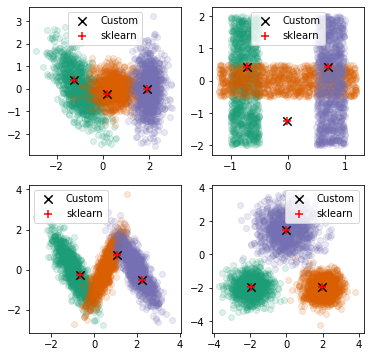

In [16]:
%%time
plot_k_means(3)